# **Projet IARN Spam Classifier**

**Réalisé par :**
 * BOUCHOUL Bouchra 191931081317
 * MEDJKOUNE Romaissa  191931081005
 * Bedjbedj Abderrahmane Hani 191931090506
 * BOUZOUAD Kaoutar 191939000658

In [203]:
import urllib.request
import sys
import tarfile
import os
import numpy
import sklearn
import email
import email.policy
import numpy as np
import re
from sklearn.metrics import accuracy_score
from html import unescape
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import collections
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
import string
from sklearn.metrics import confusion_matrix

# Loading data
cette partie permet de télécharger et d'extraire un jeu de données à partir d'une liste de fichiers et d'URL correspondantes
 

In [70]:
def download_and_extract_dataset(file_names, urls, download_directory, dataset_type):
    for (file_name, url) in zip(file_names, urls):
        file_path = os.path.join(download_directory, file_name)
        if not os.path.isfile(file_path):
            urllib.request.urlretrieve(url, file_path)
        tar_file = tarfile.open(file_path)
        
        # Remove the path by resetting it
        members = []
        for member in tar_file.getmembers():
            if member.isreg():
                member.name = os.path.basename(member.name) 
                members.append(member)
        tar_file.extractall(path=os.path.join(download_directory, dataset_type), members=members)
        tar_file.close()

In [71]:
root = "https://spamassassin.apache.org/old/publiccorpus/"

ham1_url = root + "20021010_easy_ham.tar.bz2"

ham3_url = root + "20030228_easy_ham_2.tar.bz2"

ham5_url = root + "20030228_hard_ham.tar.bz2"

ham_url = [ham1_url, ham3_url, ham5_url]

ham_filename = ["ham1.tar.bz2", "ham3.tar.bz2", "ham5.tar.bz2"]

spam1_url = root + "20021010_spam.tar.bz2"

spam4_url = root + "20050311_spam_2.tar.bz2"

spam_url = [spam1_url, spam4_url]

spam_filename = ["spam1.tar.bz2", "spam4.tar.bz2"]

path = "./data/"

if not os.path.isdir(path):
 os.makedirs(path)

download_and_extract_dataset(spam_filename, spam_url, path, "spam")

download_and_extract_dataset(ham_filename, ham_url, path, "ham")

In [72]:
def load_emails(directory, filename):
    
    with open(os.path.join(directory, filename), "rb") as f:
      
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [73]:

ham_filenames = [name for name in sorted(os.listdir("./data/ham")) if name != 'cmds']
spam_filenames = [name for name in sorted(os.listdir("./data/spam")) if name != 'cmds']

ham_emails = [load_emails("./data/ham", filename=name) for name in ham_filenames]
spam_emails = [load_emails("./data/spam", filename=name) for name in spam_filenames]

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))


In [74]:
len(spam_emails)

1897

In [75]:
ham= np.array(ham_emails,dtype=object)
spam= np.array(spam_emails,dtype=object)
spam

array([<email.message.EmailMessage object at 0x7fe02c4b5f00>,
       <email.message.EmailMessage object at 0x7fe02c4b4910>, ...,
      dtype=object)

In [76]:
X.shape, y.shape

((6098,), (6098,))

In [77]:
y

array([0, 0, 0, ..., 1, 1, 1])

# Data Preprocessing
Afin de rendre les e-mails/textes utilisables par les modèles de classification, un prétraitement est essentiel pour obtenir des résultats satisfaisants.


Conformément aux recommandations fournies, nous avons mis en place une fonction de prétraitement spécifique. Cette fonction applique différentes transformations au texte de chaque e-mail, telles que la gestion des URL, des adresses e-mail, des symboles de dollar, du code HTML, des nombres, la tokenisation et la racinisation (stemming). Ces étapes de prétraitement permettent de normaliser le texte des e-mails et de préparer les données pour la classification ultérieure.

In [78]:
#Cette fonction prétraite le corps d'un email
def preprocessing(email_contents):

  # Convert all letters to lowercase
  email_contents=email_contents.lower()
  # Remove HTML tags
  email_contents = re.sub('<[^<>]+>', ' ', email_contents)
  # Normalize URLs
  email_contents = re.sub('(http|https)://[^\s]*', 'httpaddr', email_contents)
   # Normalize email addresses
  email_contents = re.sub('\S+@\S+', 'emailaddr', email_contents)
   # Normalize numbers
  email_contents = re.sub('\d+', 'nombre', email_contents)
   # Normalize dollar signs
  email_contents = re.sub('\$', 'dollar', email_contents)
   # Stem words
  stemmer = PorterStemmer()
  words = re.findall('\w+', email_contents)
  stemmed_words = [stemmer.stem(word) for word in words]
  email_contents = ' '.join(stemmed_words)
 # Remove non-words and punctuation, replace white spaces with a single space
   # Replace non-word characters with a space
  email_contents = re.sub(r'\W+', ' ', email_contents)
    #Remove punctuation
  email_contents = email_contents.translate(str.maketrans('', '', string.punctuation)) 
    # Replace newlines and tabs with a space
  email_contents= re.sub(r'\n|\t', ' ', email_contents)
    
    # Normalize whitespace
  email_contents = re.sub(r'\s+', ' ', email_contents).strip()
  return email_contents


In [79]:
#Convert html to text
def html_to_text(html):

    email_content= re.sub(r'<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    email_content = re.sub(r'<a\s.*?>', ' HYPERLINK ', email_content, flags=re.M | re.S | re.I)
    email_content = re.sub(r'<.*?>', '', email_content, flags=re.M | re.S)
    email_content = re.sub(r'(\s*\n)+', '\n', email_content, flags=re.M | re.S)
    
    return unescape(email_content) 

#Convert email to texte (lisibe)
def email_to_text(email):
    
    html = None
    for entity in email.walk():

        #Some emails have multiple parts, each part is handled separately
        entity_type = entity.get_content_type()
        if not entity_type in ("text/plain", "text/html"):
            continue
        
        try:
            content = entity.get_content()
            #Sometimes this is impossible for encoding reasons
        except: 
            content = str(entity.get_payload())
        if entity_type == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_text(html)

In [80]:
##la fonction qui fait le preprocessig de tous les emails
def preprocess(X): 
  emails_process =[]

  for email_content in X:
    email_content=email_to_text(email_content) or " "
    email_content=preprocessing(email_content)
    emails_process.append(email_content)

  return emails_process

In [81]:
_X=preprocess(X)

Exemple pour voir le preprocessing 

In [82]:
print("\nAvant le preprocessing :\n",email_to_text(X[0]))


Avant le preprocessing :
     Date:        Tue, 20 Aug 2002 17:27:47 -0500
    From:        Chris Garrigues <cwg-exmh@DeepEddy.Com>
    Message-ID:  <1029882468.3116.TMDA@deepeddy.vircio.com>


  | I'm hoping that all people with no additional sequences will notice are
  | purely cosmetic changes.

Well, first, when exmh (the latest one with your changes) starts, I get...

can't read "flist(totalcount,unseen)": no such element in array
    while executing
"if {$flist(totalcount,$mhProfile(unseen-sequence)) > 0} {
	FlagInner spool iconspool labelup
    } else {
	FlagInner down icondown labeldown
    }"
    (procedure "Flag_MsgSeen" line 3)
    invoked from within
"Flag_MsgSeen"
    (procedure "MsgSeen" line 8)
    invoked from within
"MsgSeen $msgid"
    (procedure "MsgShow" line 12)
    invoked from within
"MsgShow $msgid"
    (procedure "MsgChange" line 17)
    invoked from within
"MsgChange 4862 show"
    invoked from within
"time [list MsgChange $msgid $show"
    (procedure "Msg_Ch

In [83]:
print("\nApres le preprocessing :\n",_X[0])


Apres le preprocessing :
 date tue nombr aug nombr nombr nombr nombr nombr from chri garrigu messag id i m hope that all peopl with no addit sequenc will notic are pure cosmet chang well first when exmh the latest one with your chang start i get can t read flist totalcount unseen no such element in array while execut if dollarflist totalcount dollarmhprofil unseen sequenc nombr flaginn spool iconspool labelup els flaginn down icondown labeldown procedur flagmsgseen line nombr invok from within flagmsgseen procedur msgseen line nombr invok from within msgseen dollarmsgid procedur msgshow line nombr invok from within msgshow dollarmsgid procedur msgchang line nombr invok from within msgchang nombr show invok from within time list msgchang dollarmsgid dollarshow procedur msgchang line nombr invok from within msgchang dollarmsg id dollarshow procedur msgshow line nombr invok from within msgshow cur eval bodi line nombr invok from within eval dollarmsgshowproc procedur folderchang line nom

#Vocabulary building
La liste de vocabulaire est destinée uniquement aux e-mails indésirables (spam).

In [84]:
#Creation list_vocabulaire
def list_vocabulaire2(X,k):
  list=X.split()
  vocabulaire=[]
  v = collections.Counter(list)
  keys = v.keys() # récupérer les clés de v
  for key in keys:
   if v[key]>k :
    vocabulaire.append(key) #ajouter les mots qui se repetent plus q k fois dans la lste vocabulaire
  return vocabulaire

In [86]:
spam=_X[len(ham_emails):] #retourner les emails spam

In [87]:
vocab = spam
vocab = ''.join(vocab)
v = list_vocabulaire2(vocab,5) # pour le k nous avonss testé ses valeurs et le k=5 donne le meilleur résultat

In [88]:
len(v)

4631

In [89]:
'''f = open("Vocabulaire.txt", "w")
for word in v:
    
    f.write(word )
    f.write('\n')'''

'f = open("Vocabulaire.txt", "w")\nfor word in v:\n    \n    f.write(word )\n    f.write(\'\n\')'

# Extract features
Une fois que nous avons nettoyé nos e-mails, nous procédons à l'extraction des caractéristiques (les mots qui se repetent plus que k fois) pour chaque e-mail. Cela nous permet de commencer la classification des e-mails.

## Représentation binaire des caractéristiques :
Dans cette étape, nous avons utilisé la fonction prédéfinie CountVectorizer
qui convertit une collection de texte (emails) en une matrice binaire (les lignes representent les exemplaires(emails) et les colonnes representent le vocabulaire) , ou chaque mot du texte se trouvant dans le vocabulaire représente pour chaque email un 1 si l’email le contient sinon 0.

In [90]:
# Création d'un objet CountVectorizer avec le vocabulaire spécifié
count_vect = CountVectorizer(binary=True, vocabulary=v)

# Transformation des e-mails en une matrice binaire d'occurrences de mots
x_bin = count_vect.transform(_X).toarray()

# Affichage de la matrice binaire d'occurrences de mots
print(x_bin)

[[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 1 1 1]]


spliting data (
Lorsque nous avons appliqué le StandardScaler, nous n'avons pas observé d'améliorations significatives ou de résultats satisfaisants)


In [91]:
x_bin_train, x_bin_test, y_bin_train,y_bin_test  = train_test_split(x_bin, y, random_state=42, test_size = 0.3)

In [92]:
x_bin_train.shape

(4268, 4631)

## Représentation des caractéristiques par comptage
La meme chose pour cette etape nous avons utilisé la fonction prédéfinie CountVectorizer pour représenter nos e-mails en utilisant la méthode de comptage. Cette méthode transforme notre vecteur de textes (les e-mails) en une matrice où chaque ligne représente un e-mail et chaque colonne représente un mot du vocabulaire sélectionné. elle compte aussi combien de fois chaque mot du vocabulaire apparaît dans chaque e-mail.

In [93]:
# Création d'un objet CountVectorizer avec le vocabulaire spécifié
count_vect = CountVectorizer(binary=False, vocabulary=v)

# Transformation des e-mails en une matrice binaire d'occurrences de mots
x_comp = count_vect.transform(_X).toarray()

# Affichage de la matrice binaire d'occurrences de mots
print(x_comp)

[[  0  47   1 ...   0   0   0]
 [  0  40  12 ...   0   0   0]
 [  0  18   2 ...   0   0   0]
 ...
 [  0   2   7 ...   0   0   0]
 [  0   2   6 ...   0   0   0]
 [  0 107  16 ...   7   7   9]]


In [94]:
'''def is_matrix_null(matrix):
    for row in matrix:
        for element in row:
            if element != 0:
                return False
    return True
    
is_matrix_null(x_comp)'''

'def is_matrix_null(matrix):\n    for row in matrix:\n        for element in row:\n            if element != 0:\n                return False\n    return True\n    \nis_matrix_null(x_comp)'

In [95]:
x_comp.shape

(6098, 4631)

In [96]:
x_comp_train, x_comp_test, y_comp_train,y_comp_test  = train_test_split(x_comp, y, random_state=42, test_size = 0.3)

# Classification



##Fonction d'evaluation des performances du modèle : Courbe ROC et Matrice de confusion
Nous avons utilisé une fonction d'évaluation pour visualiser les performances de nos modèles. Deux fonctions spécifiques ont été utilisées : la courbe ROC (Receiver Operating Characteristic) et la matrice de confusion.

In [156]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_roc_curve(model, X_test, y_test):
    # Obtenir les probabilités de prédiction du modèle sur les données de test
    y_pred_proba = model.predict_proba(X_test)[:, 1]

#Calculer les taux de faux positifs (FPR), les taux de vrais positifs (TPR) et les seuils
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

#Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

#Tracer la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test):
    # Obtenir les prédictions du modèle sur les données de test
    y_pred = model.predict(X_test)

#Calculer la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Créer une représentation visuelle de la matrice de confusion à l'aide de Seaborn
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title("Matrice de confusion")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    plt.show()


In [212]:
##une autre fonction pour comparer les modeles en 2 approches vecteurs binaire 
## et vecteurs par comptage

#compraision de courbe_roc_curve
def compare_roc_curve(model1, model2, X_test1, X_test2, y_test1, y_test2):
    # Obtenir les probabilités de prédiction des deux modèles sur les données de test
    y_pred_proba1 = model1.predict_proba(X_test1)[:, 1]
    y_pred_proba2 = model2.predict_proba(X_test2)[:, 1]

##Calculer les taux de faux positifs (FPR), les taux de vrais positifs (TPR) et les seuils pour les deux modèles
    fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_pred_proba1)
    fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_pred_proba2)

#Calculer l'aire sous la courbe ROC (AUC) pour les deux modèles
    roc_auc1 = auc(fpr1, tpr1)
    roc_auc2 = auc(fpr2, tpr2)

#Tracer la courbe ROC pour les deux modèles sur le même graphe
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Approche 1 (AUC = %0.2f)' % roc_auc1)
    plt.plot(fpr2, tpr2, color='blue', lw=2, label='Approche 2 (AUC = %0.2f)' % roc_auc2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC - Comparaison de modèles')
    plt.legend(loc="lower right")
    plt.show()


#fct pour comparer les accuracy
def compare_accuracy(model1, model2, X_test1, X_test2, y_test1, y_test2):
    # Obtenir les prédictions du modèle 1 sur les données de test 1
    y_pred1 = model1.predict(X_test1)
    # Calculer l'exactitude du modèle 1
    accuracy1 = accuracy_score(y_test1, y_pred1)

    # Obtenir les prédictions du modèle 2 sur les données de test 2
    y_pred2 = model2.predict(X_test2)
    # Calculer l'exactitude du modèle 2
    accuracy2 = accuracy_score(y_test2, y_pred2)

    # Afficher les résultats
    print("Approche 1 - Exactitude : {:.4f}".format(accuracy1))
    print("Approche 2 - Exactitude : {:.4f}".format(accuracy2))




## Implementation des modeles
Dans ce travail, nous avons utilisé cinq modèles différents pour notre étude. Ces modèles sont les suivants :

**Modeles d'apprentissage automatiques**

-Support vector machine

-Logistic regression

-Decision Trees

-Random Forest

**Modeles d'apprentissage profond**

-Neural Netowrk

Nous avons également testé ces algorithmes en utilisant deux encodages différents pour représenter les données : 

Vecteur binaire

Vecteur de compteurs

### modele 1: SVM

Après avoir expérimenté différents types de noyaux tels que RBF, nous avons constaté que le SVM avec un noyau linéaire simple offre de meilleurs résultats. Par conséquent, nous avons entraîné le modèle en utilisant deux représentations vectorielles : une représentation binaire et une représentation basée sur les compteurs.


#### Représentation binaire des caractéristiques 

In [244]:
#nous avons testé pour le C et c=0.1 donne le meilleur resultat

bin_svm_model1 = SVC(C=0.1, kernel="linear")

bin_svm_model1.fit(x_bin_train, y_bin_train)

SVC(C=0.1, kernel='linear')

In [245]:
#predictions:

test_p_bin= bin_svm_model1.predict(x_bin_test)

test_accuracy = (test_p_bin == y_bin_test).mean() * 100

print("test accuracy: {0:.10f}%".format(test_accuracy))



test accuracy: 97.8142076503%


#### Représentation  des caractéristiques  par comptage

In [187]:
comp_svm_model = SVC(C=0.2, kernel="linear")
comp_svm_model.fit(x_comp_train, y_comp_train)

SVC(C=0.2, kernel='linear')

In [188]:
train_p = comp_svm_model.predict(x_bin_train)
test_p = comp_svm_model.predict(x_bin_test)

test_accuracy2 = (test_p == y_bin_test).mean() * 100

print("test accuracy: {0:.10f}%".format(test_accuracy2))

test accuracy: 95.8469945355%


#### Comparaison des approches

In [208]:
print("Accuracy :")
compare_accuracy(bin_svm_model1, comp_svm_model, x_bin_test,x_comp_test, y_bin_test, y_comp_test)

Accuracy :
Approche 1 - Exactitude : 0.9781
Approche 2 - Exactitude : 0.9721


### modele 2: Régression logistique
Après avoir effectué plusieurs itérations, nous avons constaté que le paramètre C=20 donne les meilleurs résultats lors de l'entraînement de la régression logistique. Le paramètre C contrôle la régularisation dans le modèle, et une valeur plus élevée de C indique une pénalité plus faible pour les erreurs d'ajustement. Nous avons entraîné le modèle en utilisant deux représentations vectorielles : une représentation binaire et une représentation basée sur les compteurs.



#### Représentation binaire des caractéristiques 

test accuracy: 97.7049180328%


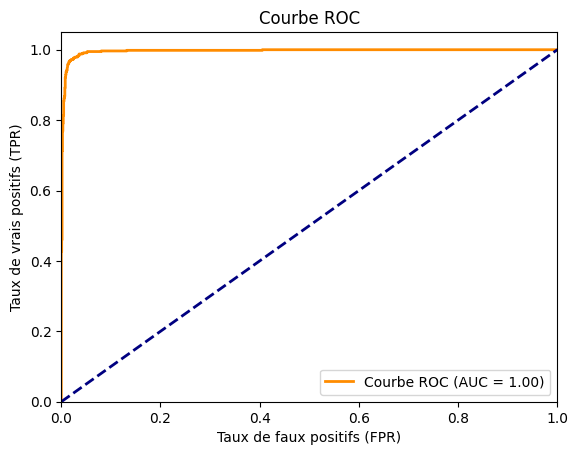

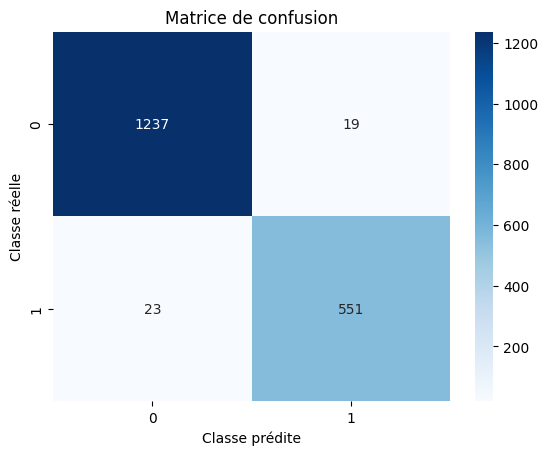

In [165]:
# Create a Logistic Regression model
model1 = LogisticRegression(max_iter=1000,C=20)

# Train the model on the training data
model1.fit(x_bin_train, y_bin_train)

# Make predictions on the test data
y_pred = model1.predict(x_bin_test)

# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred == y_bin_test).mean() * 100
plot_roc_curve(model1,x_bin_test,y_bin_test)
plot_confusion_matrix(model1,x_bin_test, y_bin_test)


#### Représentation  des caractéristiques  par comptage

test accuracy: 93.2240437158%


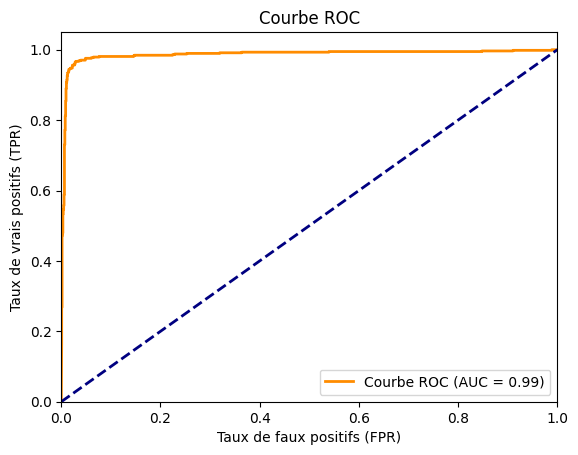

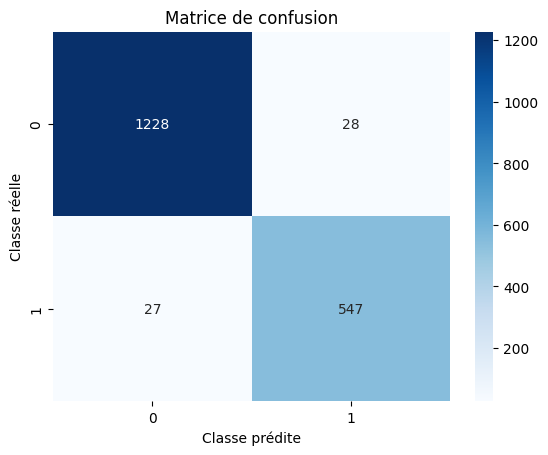

In [168]:
# Create a Logistic Regression model
model2 = LogisticRegression(max_iter=1000,C=20)

# Train the model on the training data
model2.fit(x_comp_train, y_comp_train)

# Make predictions on the test data
y_pred2 = model2.predict(x_comp_test)

# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred2 == y_comp_test).mean() * 100
plot_roc_curve(model2,x_comp_test,y_comp_test)
plot_confusion_matrix(model2,x_comp_test, y_comp_test)

#### Comparaison des approches

Accuracy :
Approche 1 - Exactitude : 0.9770
Approche 2 - Exactitude : 0.9699
ROC :


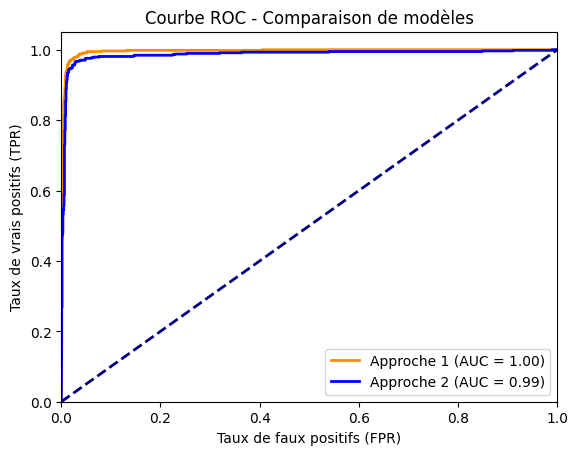

In [209]:
print("Accuracy :")
compare_accuracy(model1, model2, x_bin_test,x_comp_test, y_bin_test, y_comp_test)
print("ROC :")
compare_roc_curve(model1, model2, x_bin_test,x_comp_test, y_bin_test, y_comp_test)

### modele 3: Decision Trees

Nous avons utilisé un modèle d'arbre de décision avec les paramètres suivants : "max_features" fixé à 0.8 et "n_estimators" (nombre d'estimateurs) fixé à 1000 nous avons contraint chaque arbre de décision à utiliser uniquement 80% des caractéristiques disponibles lors de la recherche de la meilleure division à chaque étape. Ces paramètres ont été sélectionnés après plusieurs itérations et ajustements



#### Représentation binaire des caractéristiques 

test accuracy: 97.8142076503%


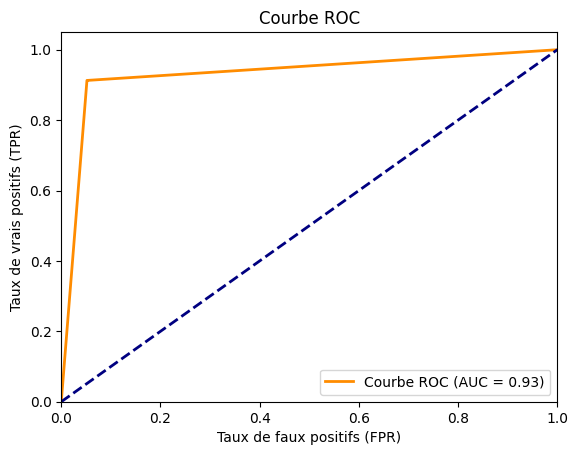

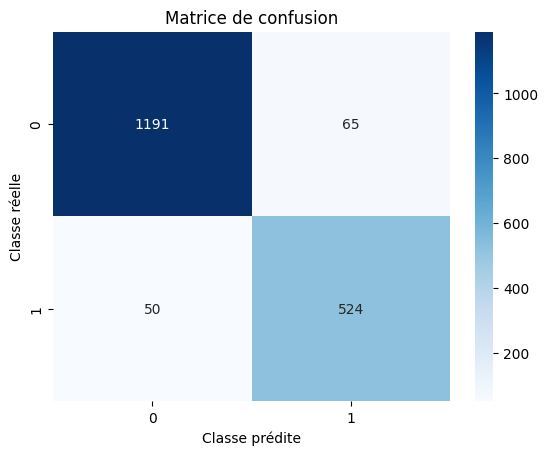

In [189]:
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree Classifier
model_dt_bin = DecisionTreeClassifier(max_features=0.8,random_state=42) #l'entrainement du modele nous avons fixé les parametres apres plusieures itérations

# Train the model on the training data
model_dt_bin.fit(x_bin_train, y_bin_train)

# Make predictions on the test data
y_pred = model_dt_bin.predict(x_bin_test)

# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred == y_bin_test).mean() * 100
plot_roc_curve(model_dt_bin,x_bin_test,y_bin_test)
plot_confusion_matrix(model_dt_bin,x_bin_test, y_bin_test)

#### Représentation  des caractéristiques  par comptage

test accuracy: 93.7158469945%


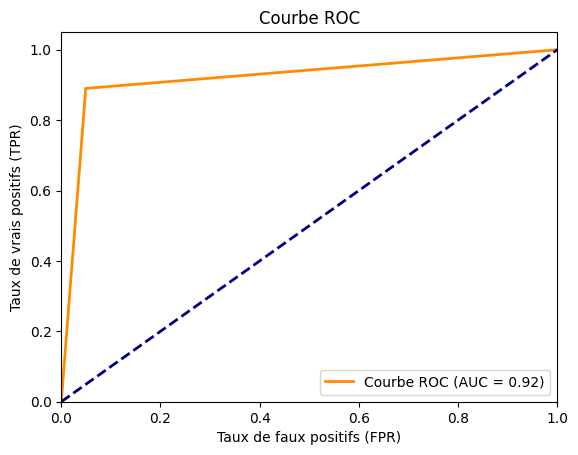

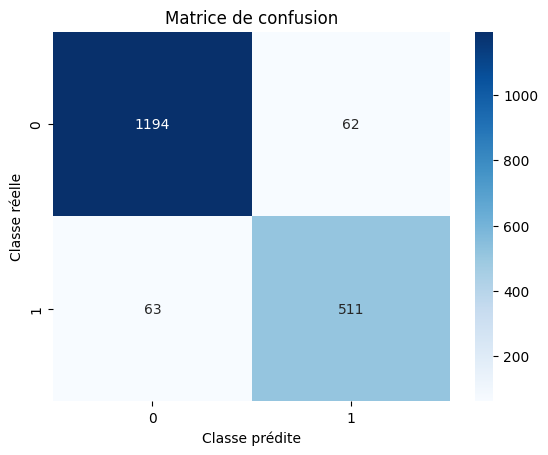

In [190]:
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree Classifier
model_dt_comp = DecisionTreeClassifier(max_features=0.8,random_state=42)#l'entrainement du modele nous avons fixé les parametres apres plusieures itérations

# Train the model on the training data
model_dt_comp.fit(x_comp_train, y_comp_train)

# Make predictions on the test data
y_pred = model_dt_comp.predict(x_comp_test)

# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred == y_comp_test).mean() * 100
plot_roc_curve(model_dt_comp,x_comp_test,y_comp_test)
plot_confusion_matrix(model_dt_comp,x_comp_test, y_comp_test)

#### Comparaison des approches 

Accuracy :
Approche 1 - Exactitude : 0.9372
Approche 2 - Exactitude : 0.9317
ROC :


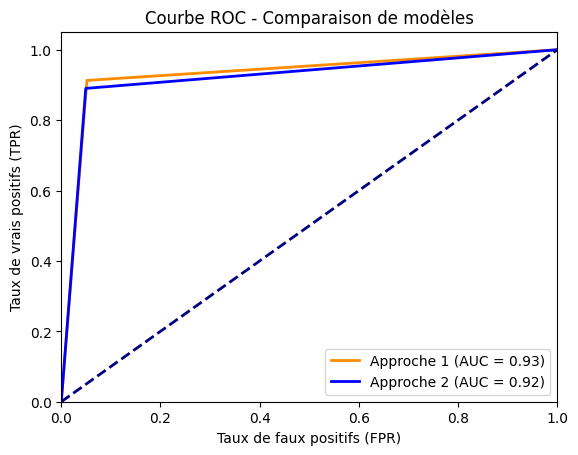

In [210]:
print("Accuracy :")
compare_accuracy(model_dt_bin, model_dt_comp, x_bin_test,x_comp_test, y_bin_test, y_comp_test)
print("ROC :")
compare_roc_curve(model_dt_bin, model_dt_comp, x_bin_test,x_comp_test, y_bin_test, y_comp_test)

### modele 4: Foret aleatoires
Nous avons utilisé un modèle de forêt aléatoire avec un nombre d'estimateurs (arbres) égal à 100. Le modèle a été entraîné en utilisant deux représentations vectorielles différentes : une représentation binaire et une représentation basée sur les compteurs.


##### Représentation binaire des caractéristiques 

test accuracy: 97.1584699454%


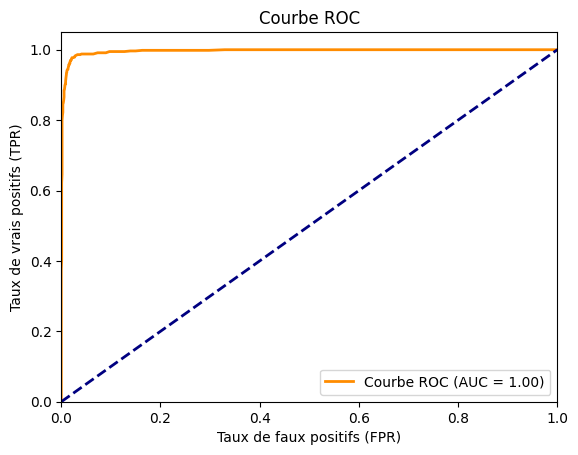

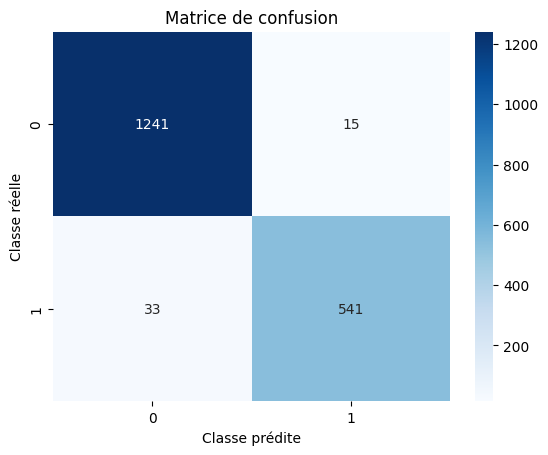

In [249]:
from sklearn.ensemble import RandomForestClassifier
# Create a Decision Tree Classifier
model_rf_bin = RandomForestClassifier(n_estimators=100,random_state=40)

# Train the model on the training data
model_rf_bin.fit(x_bin_train, y_bin_train)

# Make predictions on the test data
y_pred = model_rf_bin.predict(x_bin_test)

# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred == y_bin_test).mean() * 100
plot_roc_curve(model_rf_bin,x_bin_test,y_bin_test)
plot_confusion_matrix(model_rf_bin,x_bin_test, y_bin_test)

#### Représentation  des caractéristiques  par comptage

test accuracy: 97.3770491803%


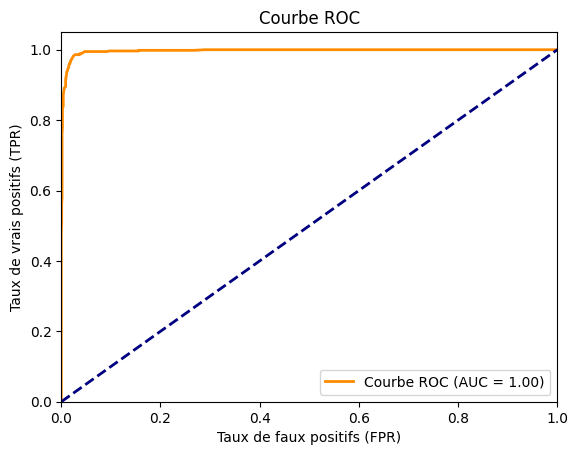

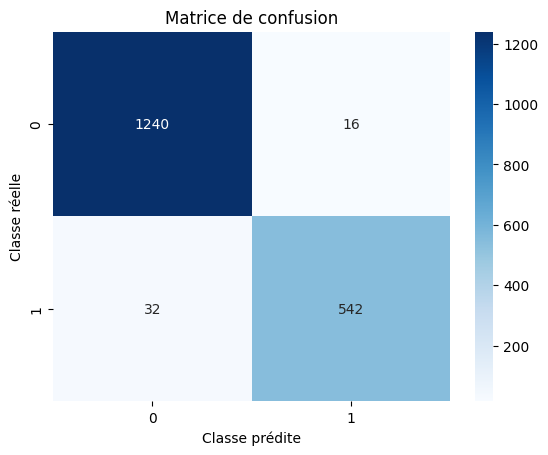

In [250]:
from sklearn.ensemble import RandomForestClassifier
# Create a Decision Tree Classifier
model_rf_comp= RandomForestClassifier(n_estimators=100,random_state=40)

# Train the model on the training data
model_rf_comp.fit(x_comp_train, y_comp_train)

# Make predictions on the test data
y_pred = model_rf_comp.predict(x_comp_test)

# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred == y_comp_test).mean() * 100
plot_roc_curve(model_rf_comp,x_comp_test,y_comp_test)
plot_confusion_matrix(model_rf_comp,x_comp_test, y_comp_test)

####Comparasion des approches 

Accuracy :
Approche 1 - Exactitude : 0.9738
Approche 2 - Exactitude : 0.9738
ROC :


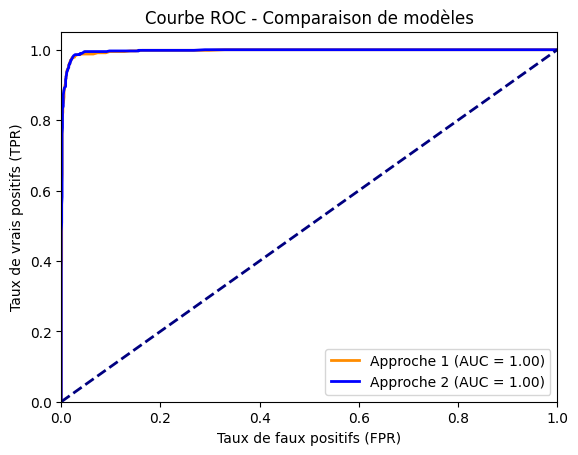

In [251]:
print("Accuracy :")
compare_accuracy(model_rf_bin, model_rf_comp, x_bin_test,x_comp_test, y_bin_test, y_comp_test)
print("ROC :")
compare_roc_curve(model_rf_bin, model_rf_comp, x_bin_test,x_comp_test, y_bin_test, y_comp_test)

### modele 5: Neural Netowrk (deep learning)
C'est un modèle de réseau de neurones classique avec deux couches denses.

Il comporte une première couche dense avec 16 neurones et une fonction d'activation ReLU. La deuxième couche est une couche de sortie avec un seul neurone et une fonction d'activation sigmoïde.

Pendant l'apprentissage, nous enregistrons les meilleurs paramètres des modèles à mesure qu'ils sont mis à jour, afin de conserver les meilleures performances observées jusqu'à présent. À la fin de l'entraînement, nous restaurons ces paramètres optimaux pour obtenir le modèle final avec les meilleures performances

#### Représentation binaire des caractéristiques 

In [226]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the neural network model
model_nn_bin = tf.keras.Sequential([
    tf.keras.layers.Dense(16, input_shape=(x_bin_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_nn_bin.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_nn_bin.fit(x_bin_train, y_bin_train, epochs=10, batch_size=1)

# Evaluate the model
loss, accuracy = model_nn_bin.evaluate(x_bin_test, y_bin_test)
print(f"Loss function = {loss:.4f}")
print(f"Accuracy = {accuracy:.4f}")

Epoch 1/10
4268/4268 [==============================] - 12s 3ms/step - loss: 0.1198 - accuracy: 0.9644
Epoch 2/10
4268/4268 [==============================] - 23s 5ms/step - loss: 0.0266 - accuracy: 0.9939
Epoch 3/10
4268/4268 [==============================] - 17s 4ms/step - loss: 0.0079 - accuracy: 0.9981
Epoch 4/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0041 - accuracy: 0.9998
Epoch 5/10
4268/4268 [==============================] - 9s 2ms/step - loss: 0.0034 - accuracy: 0.9993
Epoch 6/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 7/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 8/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0015 - accuracy: 0.9998
Epoch 9/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0048 - accuracy: 0.9988
Epoch 10/10
58/58 [==============================] - 0s 3ms/step - loss: 0

58/58 [==============================] - 0s 3ms/step
test accuracy: 97.3224043716%


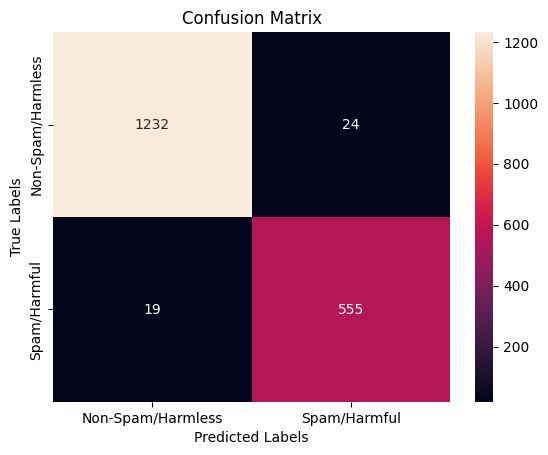

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
# Predict on test data
y_pred = model_nn_bin.predict(x_bin_test)
y_pred = np.round(y_pred).flatten()
# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred == y_bin_test).mean() * 100
# Create confusion matrix

confusion_mat = confusion_matrix(y_bin_test, y_pred)

# Plot confusion matrix
labels = ['Non-Spam/Harmless', 'Spam/Harmful']
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


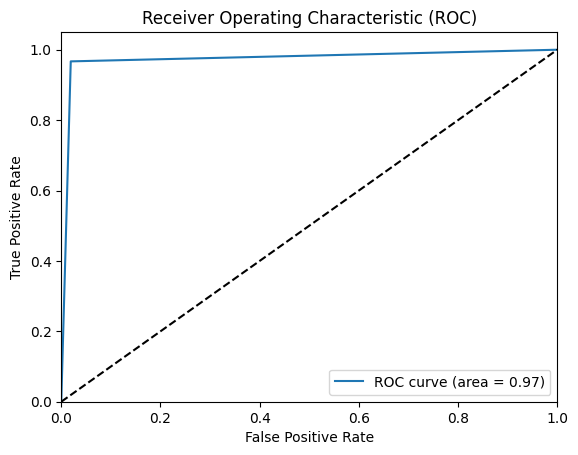

In [228]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_bin_test, y_pred)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### Représentation  des caractéristiques  par comptage

In [220]:
# Build the neural network model
model_nn_comp = tf.keras.Sequential([
    tf.keras.layers.Dense(16, input_shape=(x_comp_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_nn_comp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_nn_comp.fit(x_comp_train, y_comp_train, epochs=10, batch_size=1)

# Evaluate the model
loss, accuracy = model_nn_comp.evaluate(x_comp_test, y_comp_test)
print(f"Loss function = {loss:.4f}")
print(f"Accuracy = {accuracy:.4f}")

Epoch 1/10
4268/4268 [==============================] - 11s 2ms/step - loss: 0.2622 - accuracy: 0.9534
Epoch 2/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0500 - accuracy: 0.9866
Epoch 3/10
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0211 - accuracy: 0.9939
Epoch 4/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0190 - accuracy: 0.9981
Epoch 5/10
4268/4268 [==============================] - 9s 2ms/step - loss: 0.0194 - accuracy: 0.9970
Epoch 6/10
4268/4268 [==============================] - 11s 3ms/step - loss: 0.0389 - accuracy: 0.9988
Epoch 7/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0038 - accuracy: 0.9995
Epoch 8/10
4268/4268 [==============================] - 10s 2ms/step - loss: 0.0279 - accuracy: 0.9972
Epoch 9/10
4268/4268 [==============================] - 13s 3ms/step - loss: 0.0021 - accuracy: 0.9998
Epoch 10/10
58/58 [==============================] - 0s 4ms/step - loss: 0

58/58 [==============================] - 0s 5ms/step
test accuracy: 97.6502732240%


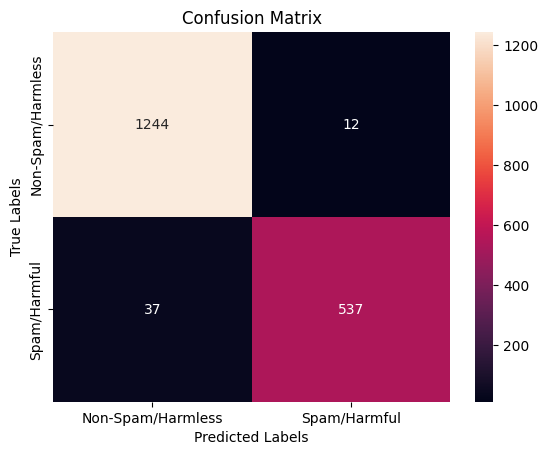

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
# Predict on test data
y_pred = model_nn_comp.predict(x_comp_test)
y_pred = np.round(y_pred).flatten()
# Evaluate the model's performance
print("test accuracy: {0:.10f}%".format(test_accuracy))
test_accuracy = (y_pred == y_comp_test).mean() * 100
# Create confusion matrix

confusion_mat = confusion_matrix(y_comp_test, y_pred)

# Plot confusion matrix
labels = ['Non-Spam/Harmless', 'Spam/Harmful']
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


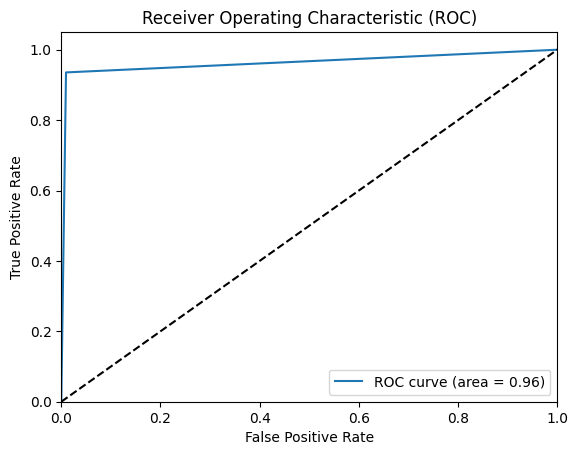

In [222]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_comp_test, y_pred)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#####Comparaison des approches

Accuracy :
Approche 1 - Exactitude : 0.9770
Approche 2 - Exactitude : 0.9699
ROC :


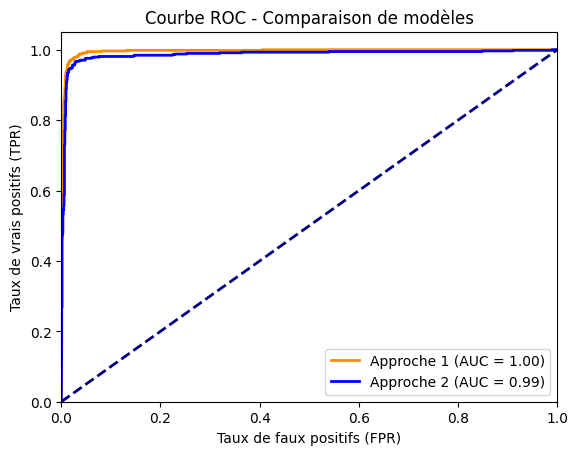

In [223]:
print("Accuracy :")
compare_accuracy(model1, model2, x_bin_test,x_comp_test, y_bin_test, y_comp_test)
print("ROC :")
compare_roc_curve(model1, model2, x_bin_test,x_comp_test, y_bin_test, y_comp_test)

# Comparasion des résultats

In [254]:
import pandas as pd
def compare_models_app(x,Model1,Model2,Model3,Model4,Model5,x_test,y_test):
 # Créer une liste de noms de modèles
 if x==1 : print("\n approche binaire \n")
 else :print("\n approche par comptage \n")
 noms_modeles = ['SVM', 'Logistic Regression', 'Decision Tree','Random Forest','Neural Network']

# Créer une liste de résultats d'exactitude pour chaque modèle
 resultats_accuracy = [Model1.score(x_test,y_test), Model2.score(x_test,y_test), Model3.score(x_test,y_test),
                       Model4.score(x_test,y_test),Model5.evaluate(x_test,y_test)[1]]

# Créer un DataFrame à partir des listes
 df = pd.DataFrame({'Modèle': noms_modeles, 'Accuracy': resultats_accuracy})

# Afficher le tableau
 print(df)


# Trouver l'index de la ligne avec la meilleure accuracy
 index_meilleur_accuracy = df['Accuracy'].idxmax()

# Récupérer le nom du modèle avec la meilleure accuracy
 modele_meilleur_accuracy = df.loc[index_meilleur_accuracy, 'Modèle']

# Récupérer la meilleure accuracy
 meilleur_accuracy = df.loc[index_meilleur_accuracy, 'Accuracy']

# Afficher le résultat
 print(f"Le modèle avec la meilleure accuracy est {modele_meilleur_accuracy} avec une accuracy de {meilleur_accuracy}")



In [255]:
compare_models_app(1,bin_svm_model1,model1,model_dt_bin,model_rf_bin,model_nn_bin,x_bin_test,y_bin_test)
compare_models_app(2,comp_svm_model,model2,model_dt_comp,model_rf_comp,model_nn_comp,x_comp_test,y_comp_test)


 approche binaire 

58/58 [==============================] - 0s 3ms/step - loss: 0.1408 - accuracy: 0.9765
                Modèle  Accuracy
0                  SVM  0.978142
1  Logistic Regression  0.977049
2        Decision Tree  0.937158
3        Random Forest  0.973770
4       Neural Network  0.976503
Le modèle avec la meilleure accuracy est SVM avec une accuracy de 0.9781420765027322

 approche par comptage 

58/58 [==============================] - 0s 3ms/step - loss: 0.4136 - accuracy: 0.9732
                Modèle  Accuracy
0                  SVM  0.972131
1  Logistic Regression  0.969945
2        Decision Tree  0.931694
3        Random Forest  0.973770
4       Neural Network  0.973224
Le modèle avec la meilleure accuracy est Random Forest avec une accuracy de 0.9737704918032787


# Analyse et conclusion

Le machine learning et le deep learning ont démontré leur efficacité dans le domaine de la détection des spams parmi les e-mails, un problème récurrent à l'ère digitale où les e-mails malveillants peuvent engendrer divers dangers, tels que le vol d'argent et l'accès à des informations privées. Dans ce projet, nous avons exploité ces approches afin de développer des modèles de classification capables de différencier les spams des e-mails légitimes.

Nous avons effectué plusieurs étapes de prétraitement des données, incluant la conversion des e-mails en texte brut et l'élimination des éléments perturbateurs tels que les nombres, les URLs et les adresses e-mail. Ensuite, nous avons comparé différents algorithmes d'apprentissage automatique et de deep learning pour chaque approche de représentation des e-mails (binaire et par comptage). Les résultats ont démontré que certains modèles, tels que le SVM, la régression logistique, l'arbre de décision, la forêt aléatoire et le réseau neuronal, ont présenté de bonnes performances en termes de précision.
Dans l'approche binaire, le modèle SVM a obtenu la meilleure précision, atteignant 97,81%. Pour l'approche par comptage, c'est la forêt aléatoire qui a affiché la meilleure précision, avec un score de 97,37%.

En comparant ces deux approches, nous avons remarqué que l'approche binaire a produit de meilleurs résultats en termes de précision pour tous les modèles évalués. Cela suggère que la représentation binaire des e-mails a mieux capturé les caractéristiques discriminantes nécessaires à la classification. Néanmoins, les différences de performance entre les deux approches restent relativement modestes.

Cette étude confirme donc l'efficacité des méthodes de machine learning et de deep learning dans la détection des spams, soulignant ainsi l'importance de développer des techniques robustes pour protéger les utilisateurs contre les e-mails malveillants.